# 2021-01-13 • Multiple ROC's

Here we repeat the simulation multiple times (each time varying one parameter), and for each repetition calculate an ROC curve (and associated area under that curve): how well could we classify all (spike_train, VI_signal)-pairs as connected or unconnected, for a range of p-value thresholds?

## Setup

In [1]:
from voltage_to_wiring_sim.notebook_init import *

Preloading: numpy, numba, matplotlib.pyplot, seaborn.
Importing from submodules … ✔
Imported `np`, `mpl`, `plt`, `sns`, `pd`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga` on **Thu 21 Jan** 2021, at 00:59 (UTC+0100).<br>
[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/1cabafb29fe4e2469e6037bcdc147003226e9a7e
) (Thu 21 Jan 2021, 00:25).
Uncommited changes to 4 files.

In [3]:
from voltage_to_wiring_sim.N_to_1_experiment import N_to_1_SimParams, simulate, plot_sim_slice

In [4]:
from voltage_to_wiring_sim.sim.neuron_params import cortical_RS

## Base parameters

In [5]:
base_params = N_to_1_SimParams(
    sim_duration = 1 * minute,
    timestep = 0.1 * ms,
    num_spike_trains = 30,
    p_connected = 0.5,
    spike_rate = 20 * Hz,
    Δg_syn = 0.8 * nS,
    τ_syn = 7 * ms,
    neuron_params = cortical_RS,
    imaging_spike_SNR = 2,
    rng_seed=1800,
);

In [6]:
sim_data = simulate(base_params);

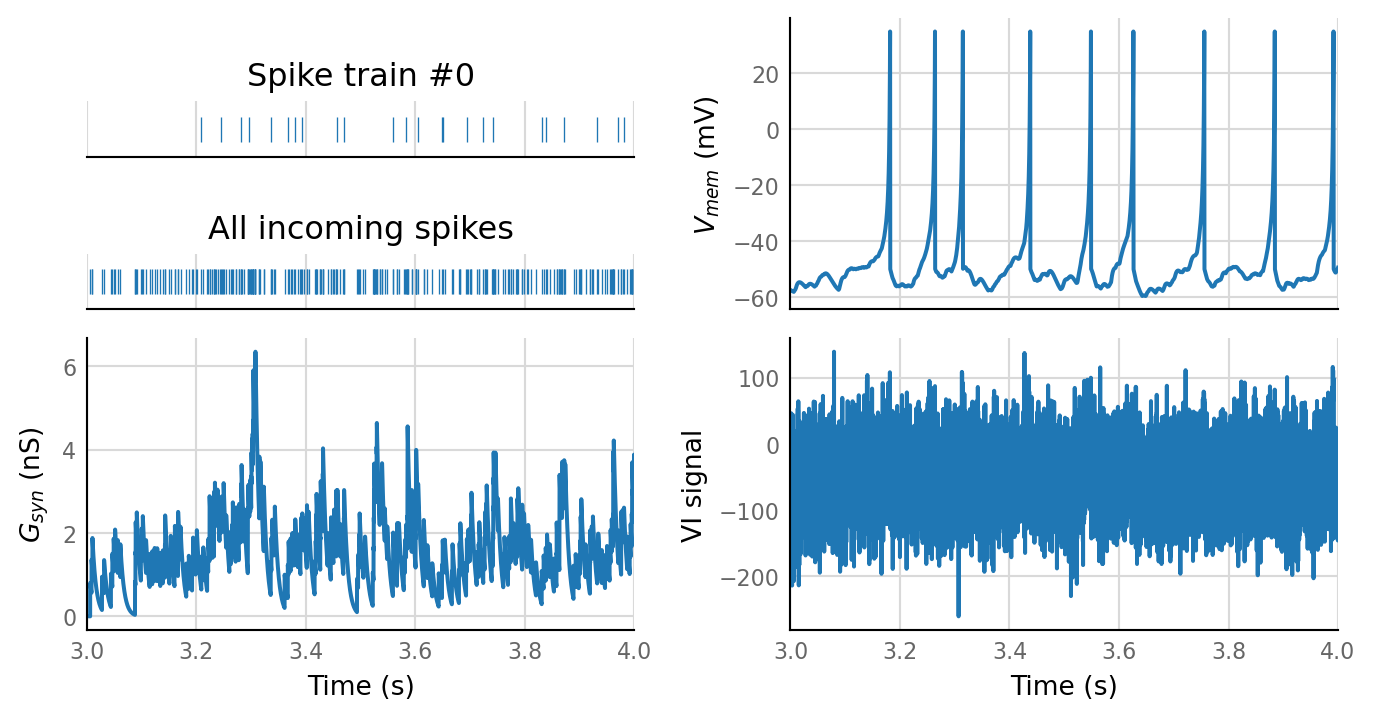

In [7]:
plot_sim_slice(sim_data, t_start=3 * second, duration=1 * second);

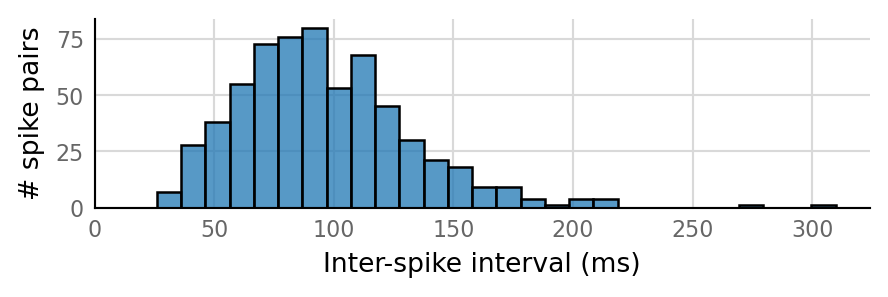

Output spike rate (1 / median ISI): 11 Hz


In [8]:
v.sim.izhikevich_neuron.show_output_spike_stats(sim_data.izh_output);

In [9]:
test_data, test_summaries = v.N_to_1_experiment.test_connections(sim_data);

Testing connections: 30/30


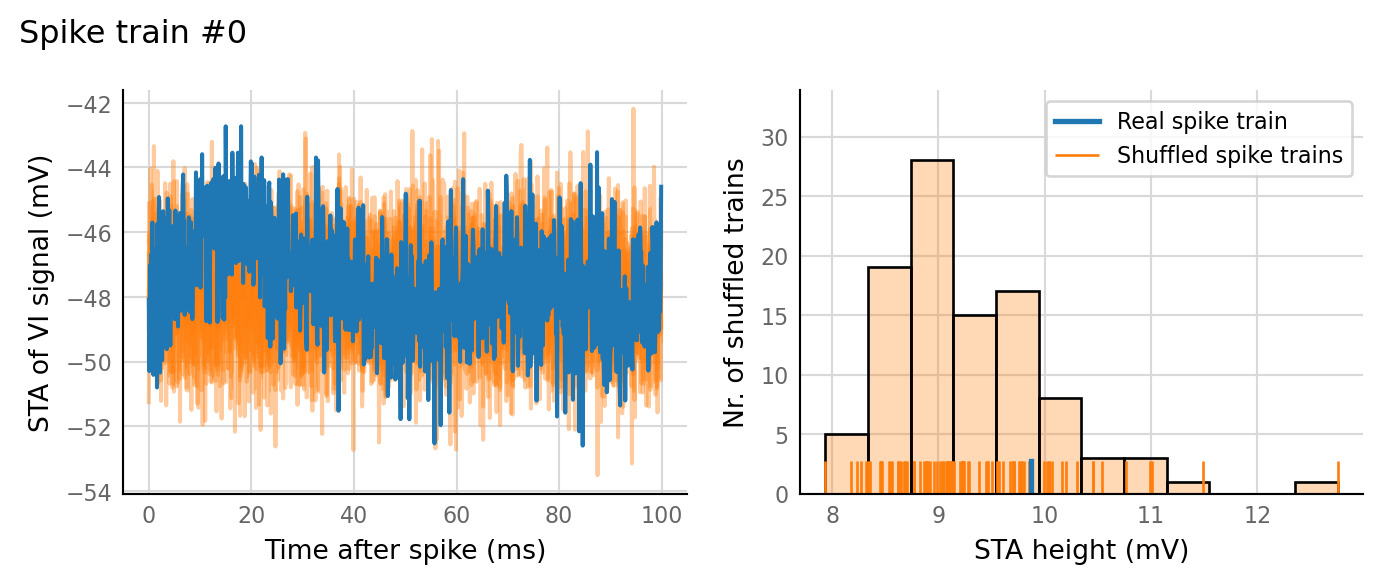

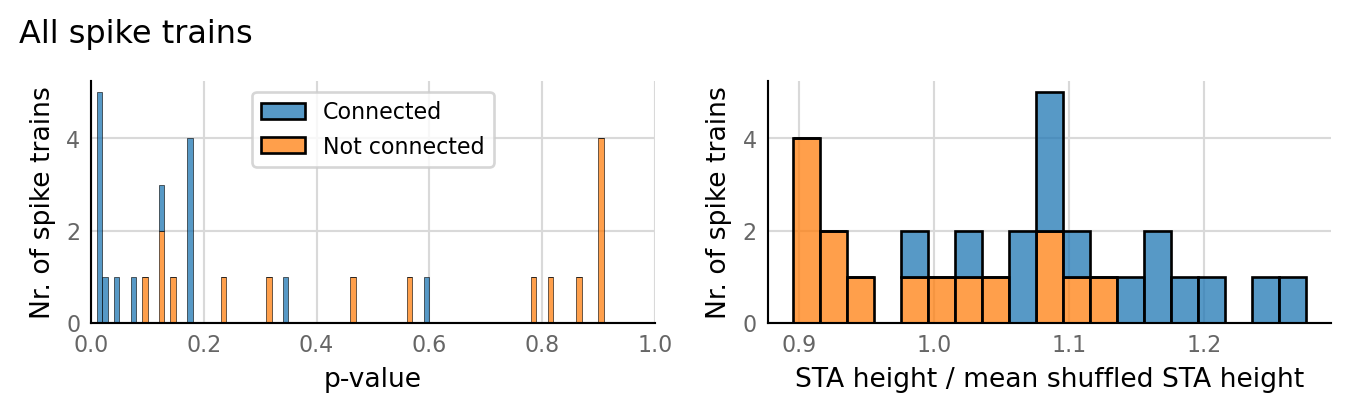

In [10]:
v.N_to_1_experiment.plot_conntest(test_data, test_summaries, sim_data)

In [11]:
classifs = v.conntest.classification.sweep_threshold(test_summaries, sim_data.is_connected);

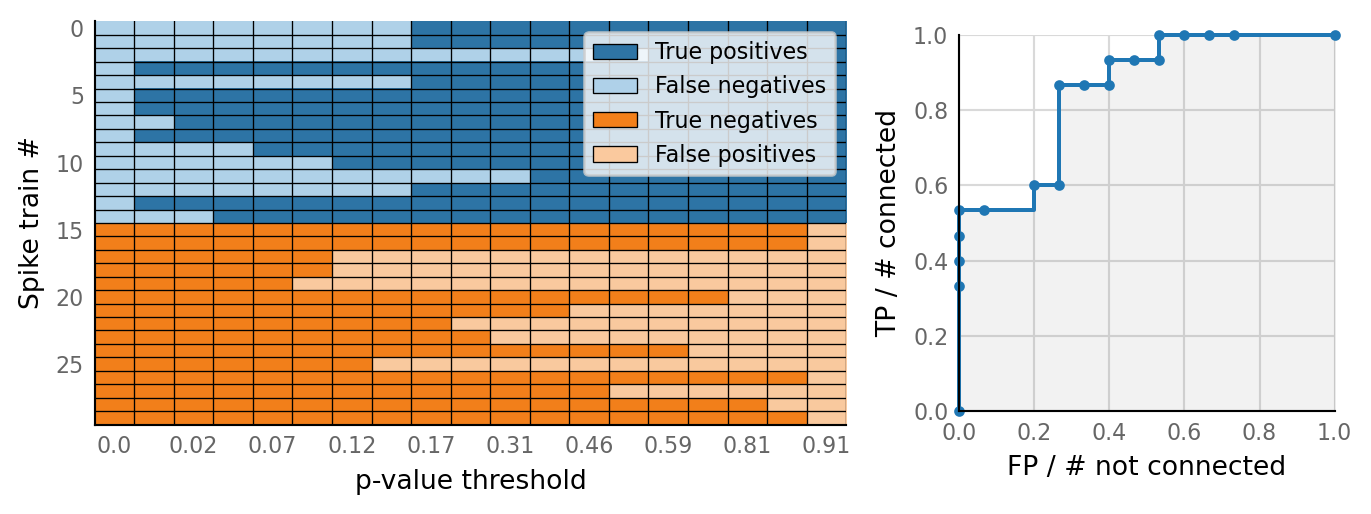

In [12]:
v.N_to_1_experiment.plot_classifications_with_ROC(classifs)

## Vary SNR

(Voltage imaging signal-to-noise ratio).

Remember: recording duration is 1 minute, and median reported VI SNR from the literature is 10.

In [13]:
test_connections = v.N_to_1_experiment.test_connections 
sweep_threshold = v.conntest.classification.sweep_threshold

def sim_and_eval(params):
    with v.time_op("Sim", end=" | "):
        sim_data = simulate(params)
    with v.time_op("Conntest"):
        test_data, test_summaries = test_connections(sim_data, inline_meter=True)
    classifs = sweep_threshold(test_summaries, sim_data.is_connected)
    return classifs

In [14]:
SNRs = [1, 2, 4, 8];

In [15]:
from copy import deepcopy

In [16]:
%%time

thr_sweeps = []

for SNR in SNRs:
    v.bsprint(f"SNR: {SNR}", end=" | ")
    params = deepcopy(base_params)
    params.imaging_spike_SNR = SNR
    thr_sweep = sim_and_eval(params)
    thr_sweeps.append(thr_sweep)

SNR: 1 | Sim: [0.46 s] | Conntest: 30/30 [1.2 s] 
SNR: 2 | Sim: [0.66 s] | Conntest: 30/30 [1.2 s] 
SNR: 4 | Sim: [0.49 s] | Conntest: 30/30 [1.2 s] 
SNR: 8 | Sim: [0.5 s]  | Conntest: 30/30 [1.3 s] 
Wall time: 7.11 s


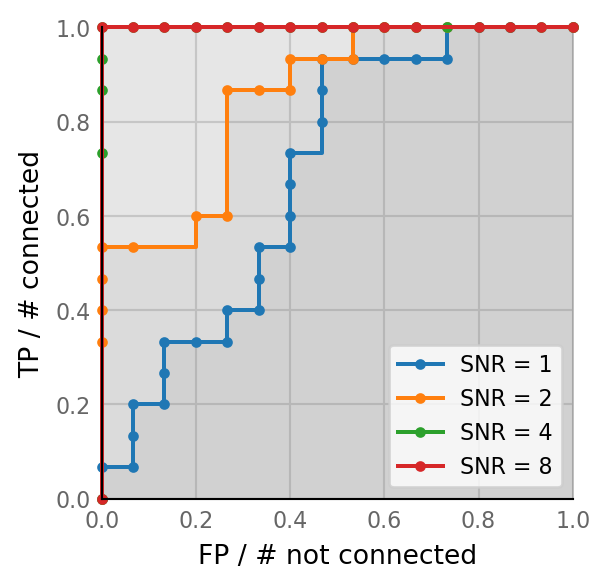

In [17]:
plot_ROC = v.conntest.classification.plot_ROC

ax = None
for i, (SNR, classifs) in enumerate(zip(SNRs, thr_sweeps)):
    ax = plot_ROC(classifs, ax,
                  label=f"SNR = {SNR}",
                  marker='.',
                  color=f"C{i}")
ax.legend();

In [18]:
def AUC(thr_sweep):
    TPRs = [tr.evaluation.TPR for tr in thr_sweep]
    FPRs = [tr.evaluation.FPR for tr in thr_sweep]
    AUC = 0
    # this is not the same as `np.trapz` e.g.
    for i in range(len(FPRs) - 1):
        AUC += (FPRs[i+1] - FPRs[i]) * TPRs[i]
    return AUC

In [19]:
df = pd.DataFrame(dict(SNR=SNRs, AUC=[AUC(s) for s in thr_sweeps]))

,SNR,AUC
0,1,0.688889
1,2,0.853333
2,4,1.000000
3,8,1.000000


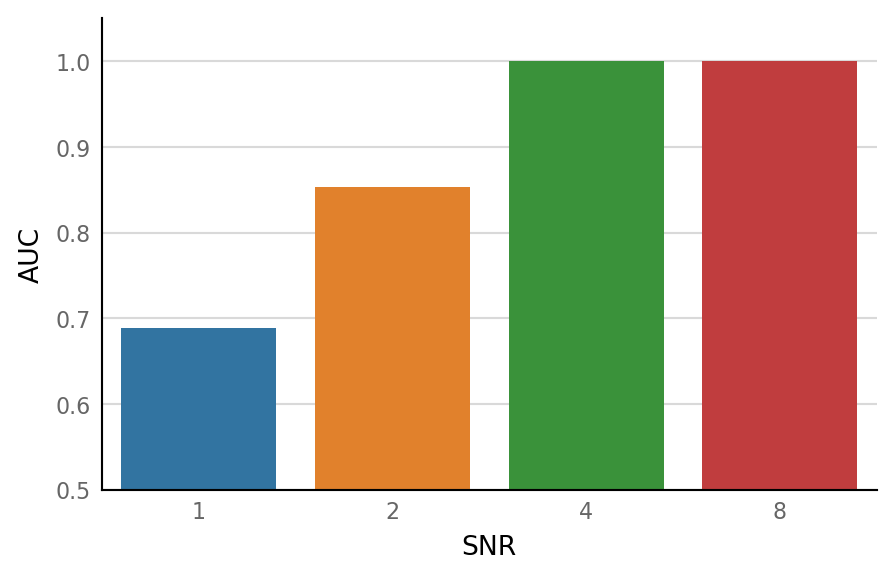

In [20]:
ax = sns.barplot(data=df, x="SNR", y="AUC")
ax.set_ylim(bottom=0.5);

## Vary recording duration

Remember: SNR here is 2, and VI photobleaching has time constant of ~10 minutes.

In [21]:
durations = (
    30 * second,
    1 * minute,
    2 * minute,
    4 * minute,
);

In [22]:
def format_duration(T):
    T_min = T / minute
    return f"{T_min:.2G} minute{'' if T_min == 1 else 's'}"

In [29]:
%%time

thr_sweeps = []

for T in durations:
    v.bsprint(f"Recording duration: {format_duration(T):<11}", end=" | ")
    params = deepcopy(base_params)
    params.sim_duration = T
    thr_sweep = sim_and_eval(params)
    thr_sweeps.append(thr_sweep)

Sim: [0.57 s] | Conntest: 30/30 | Sim: [0.57 s] | Conntest: 0/30[1.1 s] 
Sim: [0.51 s] | Conntest: 30/30 | Sim: [0.51 s] | Conntest: 0/30[1.4 s] 
Sim: [0.67 s] | Conntest: 30/30 | Sim: [0.67 s] | Conntest: 0/30[2.2 s] 
Sim: [0.63 s] | Conntest: 30/30 | Sim: [0.63 s] | Conntest: 0/30[4.3 s] 
Wall time: 11.5 s


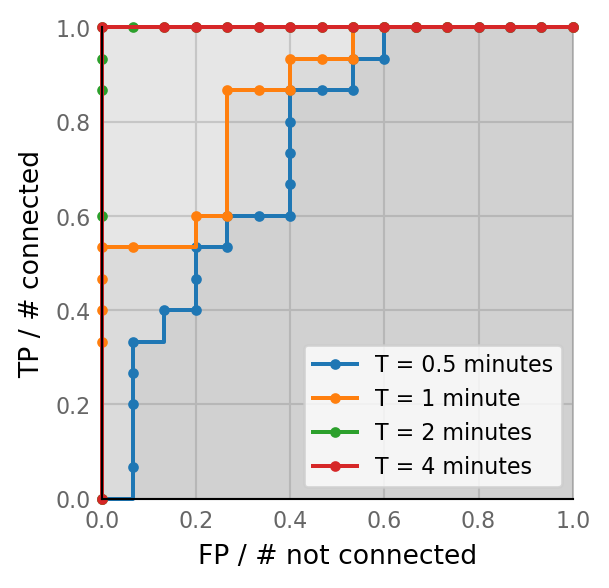

In [24]:
ax = None
for i, (T, classifs) in enumerate(zip(durations, thr_sweeps)):
    ax = plot_ROC(classifs, ax,
                  label=f"T = {format_duration(T)}",
                  marker='.',
                  color=f"C{i}")
ax.legend();

In [25]:
df = pd.DataFrame(dict(
    recording_duration=[format_duration(T) for T in durations],
    AUC=[AUC(s) for s in thr_sweeps])
)

,recording_duration,AUC
0,0.5 minutes,0.742222
1,1 minute,0.853333
2,2 minutes,1.000000
3,4 minutes,1.000000


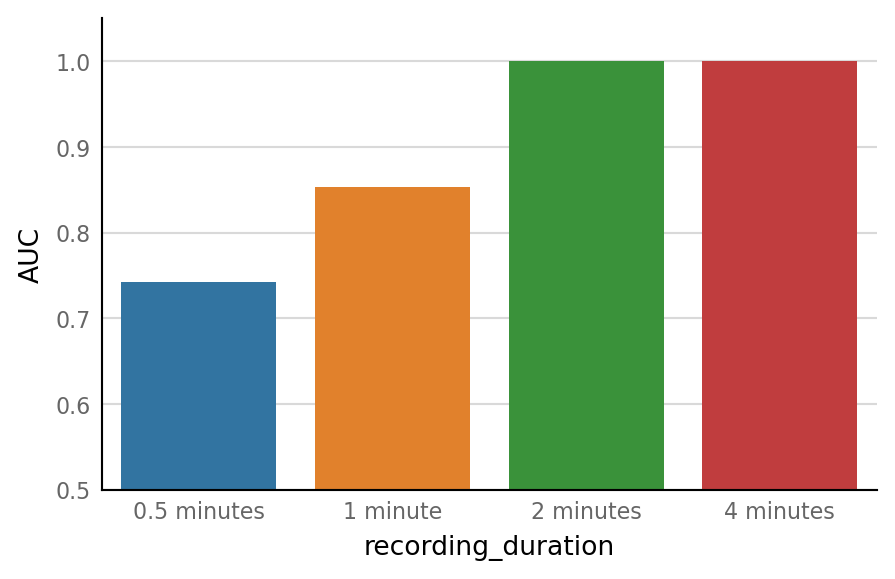

In [26]:
ax = sns.barplot(data=df, x="recording_duration", y="AUC")
ax.set_ylim(bottom=0.5);

## Reproducibility

In [27]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `tfiers` on `yoga`<br>on **Thu 21 Jan** 2021, at 01:01 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/1cabafb29fe4e2469e6037bcdc147003226e9a7e
) (Thu 21 Jan 2021, 00:25).

Uncommited changes to:
```
 M codebase/voltage_to_wiring_sim/N_to_1_experiment.py
 M codebase/voltage_to_wiring_sim/support/reproducibility.py
 M codebase/voltage_to_wiring_sim/support/util.py
 M notebooks/2021-01-13__multiple_ROC.ipynb
```

Platform:

Windows-10
CPython 3.8.6 (C:\conda\python.exe)
Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.19.5
matplotlib           3.3.3
numba                0.52.0
seaborn              0.11.1
scipy                1.6.0
scikit-learn         0.24.0
preload              2.2
nptyping             1.4.0
tqdm                 4.56.0


Full conda list:

# packages in environment at C:\conda:
#
# Name                    Version                   Build  Channel
anyio                     2.0.2            py38haa244fe_4    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
argon2-cffi               20.1.0           py38h294d835_2    conda-forge
async_generator           1.10                       py_0    conda-forge
atomicwrites              1.4.0              pyh9f0ad1d_0    conda-forge
attrs                     20.3.0             pyhd3deb0d_0    conda-forge
babel                     2.9.0              pyhd3deb0d_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.1                      py_0    conda-forge
black                     20.8b1                     py_1    conda-forge
bleach                    3.2.1              pyh9f0ad1d_0    conda-forge
bokeh       